# Tau Data Analysis - Boosted Decision Trees

The following implementation is a baseline analysis script for the <b> SUSY tau+X </b> search. Based on this [paper](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.99.012009), a similar analysis strategy is being implemented. The general workflow, at this moment, is as follows:

<center>
    <img src="../Assets/General_Workflow.png" alt="Workflow" style="width: 50%"/>
</center>

The following script implements highly popular, powerful and widely recognized machine learning algorithm (especially in High-Energy Physics community) called <b> Boosted Decision Trees </b> (BDTs). An optimized distributed gradient boosting library called <b> XGBoost </b> has been implemented. XGBoost is an open-source library providing a dedicated regularizing gradient boosting framework.

As far as XGBoost is concerned, the following pipelines are functional:
* Regression
* Binary-classification
* Multiclass-classification

Other functionalities that have been implemented:
* Stopping function preventing overfitting
* Cross-validation
    * k-fold cross-validation
* Hyperparameters tuning:
    * randomized grid-search
    * exhaustive grid-search
* GPU computing

## Analysis

### Libraries

The following script relies on the following python packages.

ROOT I/O:

* [UpROOT](https://uproot.readthedocs.io/en/latest/)

Data Processing:

* [Awkward Array](https://awkward-array.readthedocs.io/en/latest/)
* [NumPy](https://numpy.org/)
* [Pandas](https://pandas.pydata.org/)

Data Visualization:

* [Atlas MPL Style](https://atlas-mpl.readthedocs.io/en/latest/styles.html)
* [Matplotlib](https://matplotlib.org/)
* [Seaborn](https://seaborn.pydata.org/)

Machine Learning:

* [SciPy](https://scipy.org/)
* [SkLearn](https://scikit-learn.org/stable/)
* [XGBoost](https://xgboost.readthedocs.io/en/stable/)

Other:

* [tqdm](https://tqdm.github.io/)

In [1]:
import uproot as ur

import awkward as ak
import numpy as np
import pandas as pd

import atlas_mpl_style as ampl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import sklearn
import xgboost as xgb

from tqdm import tqdm
import pickle

import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

Applying ATLAS Style and supressing division by 0 warnings.

In [2]:
ampl.use_atlas_style()                  # ATLAS Style

import warnings
warnings.filterwarnings('ignore')       # Warnings supression

# plt.rc('text', usetex=True)           # LaTeX compatibility

### Algorithm

There are three available pipelines depending on the type of the algorithm:
* Regression
* Binary-classification
* Multiclass-classification

In [3]:
def algorithm_definition(algorithm_type):
    """ 
    Algorithm type defining function. Parameters: algorithm_type: ('regression', 'binary-classification', 'multiclass-classification').
    """
    if algorithm_type == 'regression':
        backgrounds = ["ttbar"]
        labels = None
        print("Regression initialized.")
    elif algorithm_type == 'binary-classification':
        backgrounds = ["sample1", "sample2"]
        labels = [
            r"sample1",
            r"sample2",
        ]
        print("Binary-classification initialized.")
    elif algorithm_type == 'multiclass-classification':
        backgrounds = ["ttbar", "wtaunu", "wmunu", "wenu", "ztautau", "zmumu", "zee", "znunu", "diboson"]
        labels = [
            r"$t \bar{t}$",
            r"$W \rightarrow \tau\nu$",
            r"$W \rightarrow \mu\nu$",
            r"$W \rightarrow e \nu$",
            r"$Z \rightarrow \tau\tau$",
            r"$Z \rightarrow \mu\mu$",
            r"$Z \rightarrow ee$",
            r"$Z \rightarrow \nu\nu$",
            r"$diboson$",
        ]
        print("Multiclass-classification initialized.")
    else:
        raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")
    
    return algorithm_type, backgrounds, labels

# algorithm_type, backgrounds, labels = algorithm_definition("regression")
algorithm_type, backgrounds, labels = algorithm_definition("binary-classification")
#algorithm_type, backgrounds, labels = algorithm_definition("multiclass-classification")

Binary-classification initialized.


### Monte Carlo

Loading MC features to be dropped at a later stage.

### Definition

The code has been developed using Release21 ntuples. However, as the tau reconstruction efficiency has been significantly improved at low $ p_T $ in Release22, all our signals have to be remade. As soon as R22 ntuples are available, they will be used. Defining the latest analysis.

In [4]:
analysis_base = "22.2.59"
daod = "MC20"
iterations = ["e"]

## Data

### Processing

Several processing steps are performed according to the following scheme:

<center>
    <img src="../Assets/Processing_Workflow.png" alt="Workflow" style="width: 60%"/>
</center>

Kinematic data (mainly momenta and related quantities) is heavily nested / jagged. Most of the ML algorithms do not work well with such complicated arrays. Hence, the rectangular format is preferred. The current solution is to set up a certain threshold for a number of entries (jets) each event can take and pad them with zeros. An example is presented below:

<center>
    <img src="../Assets/Padding.png" alt="Workflow" style="width: 60%"/>
</center>

The impact of this technique needs to be thoroughly analyzed and studied. Performing processing part.

In [5]:
# ---File Opening---
def load_calo_data(paths):
    keys = ["Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad", "Track.PT", "Track.Eta", "Track.Phi"]
    ar = []

    for i, path in enumerate(paths):
        with ur.open(path) as temp_file:
                tree = temp_file['Delphes']
                ar_temp = tree.arrays(keys, library='ak')
        ar_temp['background']=i
        ar = ak.concatenate([ar, ar_temp], axis=0)

    # ---File Opening---

    # ---Custom Parameters---
    n_max = 2                   # Number of most energetic particles to consider
    nan_thresh = 0.10           # Threshold for keeping NaN-plagued features
    # ---Custom Parameters---

    # ---Rename---
    ar["Ehad"] = ar["Tower.Ehad"]
    ar["Ehad.Eta"] = ar["Tower.Eta"]
    ar["Ehad.Phi"] = ar["Tower.Phi"]
    ar["Eem"] = ar["Tower.Eem"]
    ar["Eem.Eta"] = ar["Tower.Eta"]
    ar["Eem.Phi"] = ar["Tower.Phi"]

    # ---Sort---
    ehad_idx = ak.argsort(ar["Ehad"], ascending=False)
    ar["Ehad"] = ar["Ehad"][ehad_idx]
    ar["Ehad.Eta"] = ar["Ehad.Eta"][ehad_idx]
    ar["Ehad.Phi"] = ar["Ehad.Phi"][ehad_idx]
    eem_idx = ak.argsort(ar["Eem"], ascending=False)
    ar["Eem"] = ar["Eem"][eem_idx]
    ar["Eem.Eta"] = ar["Eem.Eta"][eem_idx]
    ar["Eem.Phi"] = ar["Eem.Phi"][eem_idx]
    track_idx = ak.argsort(ar["Track.PT"], ascending=False)
    ar["Track.PT"] = ar["Track.PT"][track_idx]
    ar["Track.Eta"] = ar["Track.Eta"][track_idx]
    ar["Track.Phi"] = ar["Track.Phi"][track_idx]
    # ---Flattening Preparation---
    var_list = []
    for feat in ak.fields(ar):
        try:                                        # Attempting to flatten features - catches all variable length features
            ak.flatten(ar[str(feat)],axis = 1)
            var_list.append(str(feat))              # Fields which need to be flattened and padded
        except Exception:
            ar = ar
    # ---Flattening Preparation---

    # ---Flattening Execution---
    for feat in var_list:
        ar[feat] = ak.pad_none(ar[feat], target = n_max, clip = True)   # Padding
        for i in range(n_max):
            ar[f"{feat}_{i}"] = ar[feat][:,i]                           # Adding a new feature on the i'th element of var-length features
        ar = ar[[x for x in ak.fields(ar) if x != feat]]                # Removing jagged arrays
    # ---Flattening Execution---

    # ---Conversion to Pandas---
    df = ak.to_pandas(ar)

    # ---Data Cleaning Execution---
    discard = ["Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad"] 
    for item in discard:
        df = df[df.columns.drop(list(df.filter(regex=item)))]
    return df

train_paths = ["/disk/atlas3/data_MC/delphes/BH_n5_M8_10000events.root", 
"/disk/atlas3/data_MC/delphes/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_10000events.root"]

test_paths = ["/disk/atlas3/data_MC/delphes/BH_n5_M8_3000events.root", 
"/disk/atlas3/data_MC/delphes/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_3000events.root"]

df = load_calo_data(train_paths)
test_df = load_calo_data(test_paths)

### Preview

Previewing the processed rectangular data as a dataframe.

In [6]:
df

,background,Ehad_0,Ehad_1,Ehad.Eta_0,Ehad.Eta_1,Ehad.Phi_0,Ehad.Phi_1,Eem_0,Eem_1,Eem.Eta_0,Eem.Eta_1,Eem.Phi_0,Eem.Phi_1,Track.PT_0,Track.PT_1,Track.Eta_0,Track.Eta_1,Track.Phi_0,Track.Phi_1
entry,,,,,,,,,,,,,,,,,,,
0,0,3639.587891,719.190552,-1.978123,1.738273,-1.053733,1.657135,630.934265,435.090424,1.851173,-1.928116,1.872957,-1.144738,383.488190,245.182495,1.746248,1.851140,1.651439,1.876621
1,0,1068.233765,766.333496,0.496297,0.195397,-0.561911,1.809715,446.381592,408.739502,0.280931,0.448131,2.642393,-0.689411,317.872620,258.308472,0.160520,0.288970,1.794903,2.648390
2,0,1382.978027,1124.768677,-0.334283,-0.053181,-0.473955,-0.009595,206.715424,84.797951,-0.008852,-0.012947,-0.062797,-0.049982,987.150635,398.615723,-0.085978,-0.012157,2.676540,-0.049499
3,0,680.536804,451.499115,1.176996,1.291627,-1.043332,-1.177721,356.106995,282.235809,1.392733,-0.745460,-1.000653,0.223091,203.691422,99.075203,1.139189,1.246957,-0.941339,-1.045308
4,0,1280.486816,795.148621,-0.100649,-0.948474,2.763140,1.242616,541.276733,466.496979,-0.193033,-0.135811,-1.260433,2.723716,1340.839478,346.050415,-0.134452,-0.127973,2.734809,-1.287248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1,595.788513,452.443878,-0.365132,-1.758252,1.062023,-2.387644,1002.693420,470.366211,-0.454707,1.324472,-1.789724,1.044995,454.151520,177.346970,-0.463159,-0.365093,-1.780188,1.146257
19996,1,768.127014,346.114502,-0.496876,0.250322,-0.462880,-2.985781,856.552917,179.672852,-0.832666,-2.791093,0.332786,-2.595283,913.256897,629.317810,0.545503,-0.830461,0.066468,0.337734
19997,1,1333.654297,464.437531,-0.120770,2.239476,1.602965,2.268943,1214.477051,267.658752,-0.199195,2.280725,-1.374458,2.395489,796.298584,450.424713,-0.109332,0.478944,1.594036,1.395689


In [7]:
test_df

,background,Ehad_0,Ehad_1,Ehad.Eta_0,Ehad.Eta_1,Ehad.Phi_0,Ehad.Phi_1,Eem_0,Eem_1,Eem.Eta_0,Eem.Eta_1,Eem.Phi_0,Eem.Phi_1,Track.PT_0,Track.PT_1,Track.Eta_0,Track.Eta_1,Track.Phi_0,Track.Phi_1
entry,,,,,,,,,,,,,,,,,,,
0,0,1916.087280,294.444641,-1.901886,-1.819479,-1.148246,-1.155881,1381.981201,435.810608,1.633523,-1.950425,1.703747,-1.177718,312.342255,54.482765,1.635234,-1.951647,1.700085,-1.178183
1,0,765.279846,537.865601,0.682922,0.278969,-0.692505,2.485827,268.945679,181.187836,-0.120614,0.236567,1.495762,2.570801,164.125381,154.912369,-0.106249,0.638231,1.492771,-0.683568
2,0,1452.938110,811.206665,-0.309819,-0.156196,-0.382403,2.997664,249.836441,68.892265,-0.363206,-0.180958,-0.477575,2.689658,326.677551,191.995605,-0.361496,-0.361057,-0.483760,-0.481633
3,0,1258.597412,378.766663,-3.658907,1.368315,-2.166087,-0.893988,1649.828369,151.550217,1.316173,1.051101,-1.013593,-1.140760,131.985168,69.600563,1.305208,-0.532487,-1.019072,0.178605
4,0,993.823059,783.499084,-0.128401,-0.960292,-1.364280,1.277206,373.180450,356.762695,0.078747,-0.187474,-1.020463,-1.230199,295.389404,264.143707,0.075572,-0.179111,-1.021391,-1.224550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6195,1,1266.102051,861.981689,1.047016,-0.563510,2.517616,3.111117,1351.933472,213.754822,0.446067,-4.870403,-0.677134,1.900929,723.634705,428.703491,0.446247,1.016777,-0.672979,2.545664
6196,1,1107.446533,868.855347,-0.197161,-1.331553,1.457779,-2.876368,484.531647,258.569397,0.857130,-0.128066,-0.119993,-2.188762,530.646362,445.913055,0.410024,0.859948,-0.076421,-0.110583
6197,1,1036.375244,1035.248779,-0.679812,0.318222,-2.882783,0.207284,394.714661,169.949631,-0.614461,-0.006620,-2.830482,1.612999,564.817322,477.802368,-0.467889,0.368600,-1.309757,0.276835


Checking if there are any missing values.

In [8]:
df.isnull().sum()

background     0
Ehad_0         0
Ehad_1         0
Ehad.Eta_0     0
Ehad.Eta_1     0
Ehad.Phi_0     0
Ehad.Phi_1     0
Eem_0          0
Eem_1          0
Eem.Eta_0      0
Eem.Eta_1      0
Eem.Phi_0      0
Eem.Phi_1      0
Track.PT_0     0
Track.PT_1     0
Track.Eta_0    0
Track.Eta_1    0
Track.Phi_0    0
Track.Phi_1    0
dtype: int64

In [9]:
for key,value in df.isnull().sum().iteritems():
    if value!=0:
        print(key,",",value)

### (Optional) Padding

Checking padding for NaN, 0, -999 and mean value.

In [10]:
def padding_maker(run, padding_type='0'):
    """
    Padding making function. Parameters: run (True, False), padding_type ('NaN', '0', '-999', 'mean').
    """
    if run:
        if padding_type == 'NaN':
            pass
        elif padding_type == '0':
            df.fillna(0, inplace = True)
        elif padding_type == '-999':
            df.fillna(-999, inplace = True)
        elif padding_type == 'mean':
            [df[column].fillna(df[column].mean(), inplace = True) for column in df.columns]
            # for column in df.columns:
            #     df[column].fillna(df[column].mean(), inplace = True)
        else:
            raise Exception("Unsupported type of a padding. Only 'NaN', '0', '-999', 'mean' allowed.")
    
    else:
        print('No padding performed.')    

# padding_maker(True, 'NaN')
# padding_maker(True, '0')
# padding_maker(True, '-999')
# padding_maker(True, 'mean')

padding_maker(False)

No padding performed.


### Balance

Checking the balance of the data with and without taking into account the "weight" feature.

### Shuffle

Shuffling the data to prevent any unnecessary correlations.

In [11]:
df = df.sample(frac=1)
df

,background,Ehad_0,Ehad_1,Ehad.Eta_0,Ehad.Eta_1,Ehad.Phi_0,Ehad.Phi_1,Eem_0,Eem_1,Eem.Eta_0,Eem.Eta_1,Eem.Phi_0,Eem.Phi_1,Track.PT_0,Track.PT_1,Track.Eta_0,Track.Eta_1,Track.Phi_0,Track.Phi_1
entry,,,,,,,,,,,,,,,,,,,
16416,1,1304.432129,557.241821,-0.188276,2.202757,2.575375,2.697725,228.296204,92.167168,0.178985,2.410264,-0.888573,2.728963,1019.798950,516.296082,0.190004,-0.142941,-0.877729,2.551253
17276,1,891.703064,451.529510,-0.071646,-0.938760,2.813250,-2.453720,957.989380,141.582535,-0.637260,-1.061686,-0.271529,-2.794802,414.133240,131.361984,-0.637473,-1.078310,-0.277801,-2.790780
733,0,2036.728760,723.844666,0.089303,0.453377,2.902609,-0.438280,577.853943,366.270172,-0.239383,0.060041,-0.006456,2.902280,1297.450439,1235.083862,-0.242572,0.062879,-0.012950,2.899904
11518,1,1145.579956,792.425537,-0.243427,0.253799,1.907396,-2.786067,1047.604492,474.798431,0.928978,0.298909,-0.244744,-2.665667,811.021423,733.448914,-0.530520,-0.141527,0.857551,-1.937688
6517,0,766.656250,734.455872,0.275185,-0.411881,-0.400464,0.867954,351.613159,265.175812,-0.484077,0.161077,-2.251002,-2.319808,354.401978,247.529846,-0.411576,0.203789,0.854647,-0.440822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,0,1648.054321,1300.123657,-0.518346,0.039703,-1.042973,2.266451,504.826996,287.784912,0.031271,1.265428,2.114829,2.171016,858.575867,800.201477,-0.511066,0.903398,-1.039077,-0.499831
6200,0,2044.651367,1619.300171,0.743390,-0.892453,1.059589,-2.285239,1229.481567,132.713486,-0.890266,0.735875,-2.346927,1.159140,821.429016,298.970947,-0.896559,0.733688,-2.354550,1.162813
2511,0,2501.378662,611.616882,0.886324,-1.482134,0.797665,-2.470031,261.243317,129.781281,0.880700,-1.603278,0.812645,3.135678,166.638565,155.361343,-0.281964,0.877367,0.573257,0.809585


### Weight Feature

Dropping the "weight" feature to be applied during the histograms plotting.

### (Optional) Features Investigation

Dropping particular features of interest to see how much the correlation and feature importance plots change.

In [12]:
def feature_drop(run, amount='single', feature='jet_n_btag'):
    """ 
    Feature dropping function. Parameters: run (True, False), amount ('single', 'all'), feature ('string' - feature of interest from the dataframe).
    """
    if run:
        if amount == 'single':
            df.drop(feature, axis=1, inplace=True)
            # df = df.loc[:, df.columns != feature]     # 2nd method
        elif amount == 'all':
            df.drop(df.columns.difference([feature,'background']), axis=1, inplace=True)
        else:
            raise Exception("Unsupported type of a drop. Only 'single' or 'all' allowed.")
            
    else:
        print('No dropping performed.')

(1) Dropping the desired feature (change the first parameter to False if this step is to be skipped).

In [13]:
# feature_drop(True, 'single', 'jet_isBjet_0')
# feature_drop(True, 'single', 'jet_isBjet_1')
# feature_drop(True, 'single', 'jet_isBjet_2')

feature_drop(False)

No dropping performed.


(2) Dropping all features except the desired feature (change the first parameter to False if this step is to be skipped).

In [14]:
# feature_drop(True, 'all', 'jet_isBjet_0')

feature_drop(False)

No dropping performed.


## Boosted Decision Trees

### Objective & Metric

Defining an objective and a metric.

In [15]:
def objective_metric_definition(algorithm_type):
    """ 
    Objective and metric definition function. Parameters: algorithm_type: ('regression', 'binary-classification', 'multiclass-classification').
    """
    
    if algorithm_type == "regression":
        objective = "reg:squarederror"                  # Possibilities: reg:squarederror, reg:squaredlogerror, reg:logistic, reg:pseudohubererror
        metric = "rmse"                                 # Possibilities: rmse, rmsle, mae, mape, mphe

    elif algorithm_type == "binary-classification":
        objective = "binary:logistic"                   # Possibilities: binary:logistic, binary:logitraw, binary:hinge
        metric = "logloss"                              # Possibilities: logloss, error, error@t, auc

    elif algorithm_type == "multiclass-classification":
        objective = "multi:softmax"                     # Possibilities: multi:softmax, multi:softprob
        metric = "mlogloss"                             # Possibilities: mlogloss, merror, auc
        
    else:
        raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")
    
    return objective, metric

objective, metric = objective_metric_definition(algorithm_type)

### Train-Test Split

Splitting the data into train and test subsets. Depending on the type of the algorithm, a label is determined as follows:
* for regression, the $y$-label is set according to the Fields_Target.py,
* for binary- and multiclass-classification, the $y$-label is set as the "background" feature.

In [16]:
print(algorithm_type)
def split_data_label(algorithm_type, df, split=False):
    if algorithm_type == 'regression':
        if ("n" in flds[0]) and ("divide" in flds[0]):
            y = df[f"{flds[0]['name']}_{flds[0]['n']-1}"]/flds[0]['divide']
            X = df.drop(f"{flds[0]['name']}_{flds[0]['n']-1}", axis = 1)
        elif "n" in flds[0]:
            y = df[f"{flds[0]['name']}_{flds[0]['n']-1}"]
            X = df.drop(f"{flds[0]['name']}_{flds[0]['n']-1}", axis = 1)
        elif "divide" in flds[0]:
            y = df[flds[0]['name']]/flds[0]['divide']
            X = df.drop(flds[0]['name'], axis = 1)
        else:
            y = df[flds[0]['name']]
            X = df.drop(flds[0]['name'], axis = 1)
    elif (algorithm_type == 'binary-classification') or (algorithm_type == 'multiclass-classification'):
        y = df['background']
        X = df.drop('background', axis = 1)
    
    if split==True:
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, 
            test_size = 0.1, 
            random_state = 1,
        )
        return X_train, X_test, y_train, y_test
    else:
        return X, y
X_train, X_val, y_train, y_val = split_data_label(algorithm_type, df, split=True)
X_test, y_test = split_data_label(algorithm_type, test_df, split=False)

binary-classification


### Preview

Previewing the $ y $- and $ x $-subsets.

In [17]:
X_train.head()

,Ehad_0,Ehad_1,Ehad.Eta_0,Ehad.Eta_1,Ehad.Phi_0,Ehad.Phi_1,Eem_0,Eem_1,Eem.Eta_0,Eem.Eta_1,Eem.Phi_0,Eem.Phi_1,Track.PT_0,Track.PT_1,Track.Eta_0,Track.Eta_1,Track.Phi_0,Track.Phi_1
entry,,,,,,,,,,,,,,,,,,
15031,443.022705,327.463501,0.041525,-1.314004,2.146670,0.927263,312.672699,183.647644,-0.257888,-0.456006,0.324000,-0.957456,382.653412,130.448029,-0.257531,0.033596,0.325456,2.261696
1992,2661.782959,987.821167,-0.255604,-1.035969,-0.762273,2.535619,636.258789,377.343170,1.319221,-0.774896,2.178724,2.517020,278.457642,185.664246,1.305638,-0.782705,2.166179,2.515290
1894,1027.864014,869.889404,-1.101148,0.933922,0.155208,2.301018,1588.205566,359.447937,-0.084205,0.919174,-1.049494,2.295302,684.732056,156.846466,1.037947,-1.101800,3.001321,0.091001
7299,1587.906982,854.952637,-0.904477,1.267624,2.457669,-0.107115,354.168671,275.885223,1.200448,1.479026,-0.081980,-1.152315,303.238953,275.700836,0.618738,-0.063262,-1.111598,-1.071560
18472,1363.883545,402.081329,-2.811739,0.192890,-0.343959,-1.331078,1731.152588,413.372040,-0.367170,0.450152,0.827580,-2.851246,412.485168,246.593094,-0.379245,0.297629,0.828038,-1.708956


In [18]:
X_test.head()

,Ehad_0,Ehad_1,Ehad.Eta_0,Ehad.Eta_1,Ehad.Phi_0,Ehad.Phi_1,Eem_0,Eem_1,Eem.Eta_0,Eem.Eta_1,Eem.Phi_0,Eem.Phi_1,Track.PT_0,Track.PT_1,Track.Eta_0,Track.Eta_1,Track.Phi_0,Track.Phi_1
entry,,,,,,,,,,,,,,,,,,
0,1916.087280,294.444641,-1.901886,-1.819479,-1.148246,-1.155881,1381.981201,435.810608,1.633523,-1.950425,1.703747,-1.177718,312.342255,54.482765,1.635234,-1.951647,1.700085,-1.178183
1,765.279846,537.865601,0.682922,0.278969,-0.692505,2.485827,268.945679,181.187836,-0.120614,0.236567,1.495762,2.570801,164.125381,154.912369,-0.106249,0.638231,1.492771,-0.683568
2,1452.938110,811.206665,-0.309819,-0.156196,-0.382403,2.997664,249.836441,68.892265,-0.363206,-0.180958,-0.477575,2.689658,326.677551,191.995605,-0.361496,-0.361057,-0.483760,-0.481633
3,1258.597412,378.766663,-3.658907,1.368315,-2.166087,-0.893988,1649.828369,151.550217,1.316173,1.051101,-1.013593,-1.140760,131.985168,69.600563,1.305208,-0.532487,-1.019072,0.178605
4,993.823059,783.499084,-0.128401,-0.960292,-1.364280,1.277206,373.180450,356.762695,0.078747,-0.187474,-1.020463,-1.230199,295.389404,264.143707,0.075572,-0.179111,-1.021391,-1.224550


In [19]:
y_train.head()

entry
15031    1
1992     0
1894     0
7299     0
18472    1
Name: background, dtype: int64

### Model

#### Parameters

Defining the initial hyperparameter values.

In [21]:
hyperparameters = {
    # ---General Parameters---
    'booster':'gbtree',                     # type of model to run at each iteration
    # ---General Parameters---

    # ---Booster Parameters---
    'n_estimators':20000,                    # number of classifiers
    'learning_rate':0.001,                    # learning rate
    'max_depth':5,                          # the maximum depth of a tree
    'min_child_weight':1,                   # defines the minimum sum of weights in a child
    'gamma':0,                              # specifies minimum loss reduction to make a split
    'subsample':1.0,                        # defines random fraction of observations for each tree
    'colsample_bytree':1.0,                 # defines random fraction of columns for each tree
    'reg_alpha':0,                          # L1 regularization term on weights
    'reg_lambda':0,                         # L2 regularization term on weights
    'scale_pos_weight':1,                   # balance of positive and negative weights
    'max_delta_step':0,                     # tree’s weight estimation
    # ---Booster Parameters---

    # ---Learning Task Parameters---
    'objective':objective,                  # defines loss function to be minimized
    'tree_method':'gpu_hist',               # tree constructing method. Possibilities: hist, gpu_hist, approx, exact
    'gpu_id':0,                             # selects which GPU card to use (uncheck in case of not using gpu)
    'seed':1,                               # seed statistic number
    # ---Learning Task Parameters---

    # ---Multiclass Parameters---
    'num_class':len(np.unique(y_train))         # number of classes (for multiclass-classification only)
    # ---Multiclass Parameters---
}

if algorithm_type != 'multiclass-classification':
    del hyperparameters['num_class']

Defining the fit parameter values.

In [22]:
fit_parameters= {
    'X':X_train,
    'y':y_train,
    "eval_set" : [(X_train, y_train), (X_val, y_val)],
    'eval_metric':metric,
    'early_stopping_rounds':1000,
    'verbose':0
}

#### Fitting

Fitting the model with hyper-and fit-parameters.

In [23]:
if algorithm_type == 'regression': 
    xgb_model = xgb.XGBRegressor(**hyperparameters)
elif (algorithm_type == 'binary-classification') or (algorithm_type == 'multiclass-classification'):
    xgb_model = xgb.XGBClassifier(**hyperparameters)
else:
    raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")

xgb_model.fit(**fit_parameters)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.001, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=20000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=1, ...)

#### Prediction

Making the predictions and estimating prediction probabilities (the latter only for binary- and multiclass-classification).

In [24]:
predictions = xgb_model.predict(
    X_test, 
    ntree_limit=xgb_model.best_ntree_limit
)

if algorithm_type == 'regression':
    print("Not available for regression.")

elif (algorithm_type == 'binary-classification') or (algorithm_type == 'multiclass-classification'):
    predictions_proba = xgb_model.predict_proba(
        X_test,
        ntree_limit=xgb_model.best_ntree_limit
    )

else:
    raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")

#### Loss

Plotting the loss with respect to the number of trees. The optimal tree number is established when there is no improvement in the loss for succeeding, specific number of trees determined in the stopping functionality preventing overfitting.

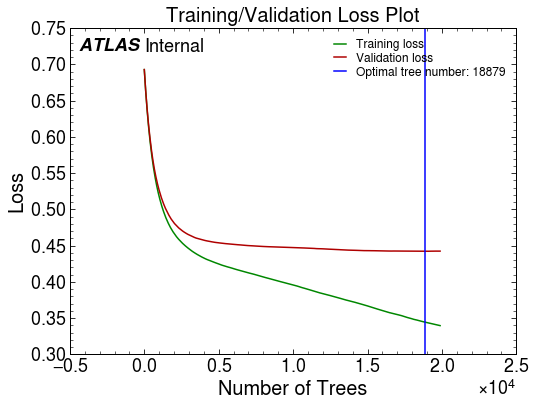

In [25]:
def loss_plotter(metric):
    """ 
    Loss plotting function. Parameters: metric ('string' - chosen metric for a given model).
    """

    fig, ax = plt.subplots(1,1, figsize=(8,6))

    ax.plot(xgb_model.evals_result()["validation_0"][metric], label="Training loss")
    ax.plot(xgb_model.evals_result()["validation_1"][metric], label="Validation loss")

    ax.axvline(xgb_model.best_ntree_limit , color="blue", label=f"Optimal tree number: {xgb_model.best_ntree_limit}")

    ax.set_xlabel("Number of Trees")
    ax.set_ylabel("Loss")

    ax.legend(loc="upper right", prop={'size': 12}, labelspacing=0.1, handlelength=1, handleheight=1)
    
    ax.set_title('Training/Validation Loss Plot')

    # ---ATLAS Label---
    ampl.draw_atlas_label(0.02, 0.97)
    # ---ATLAS Label---

    plt.show()

loss_plotter(metric)

#### Feature Importance

Plotting the feature importance score for all or specific amount of features.

ValueError: shape mismatch: objects cannot be broadcast to a single shape

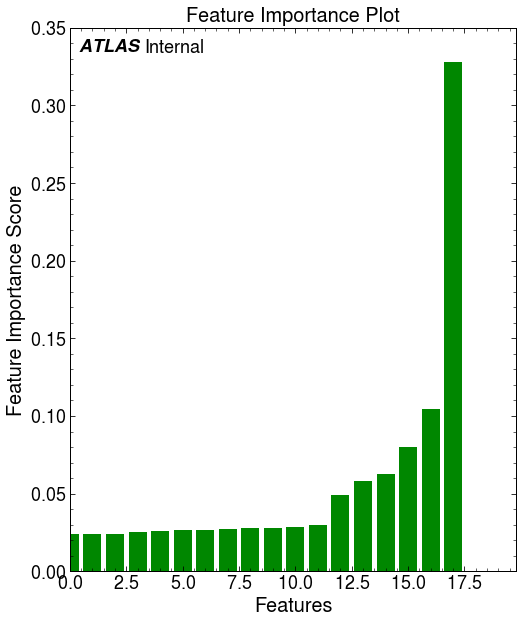

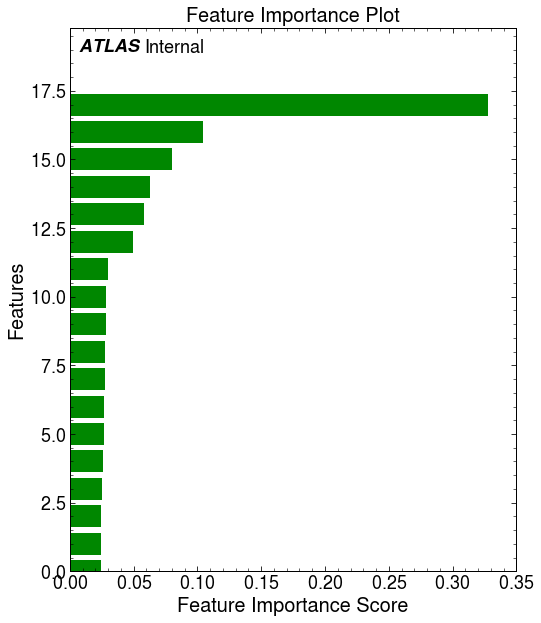

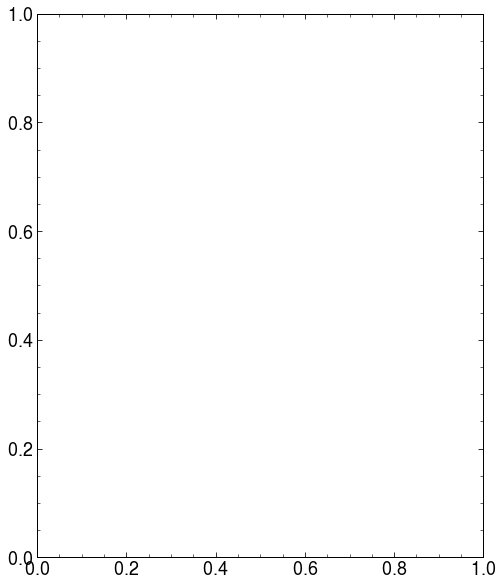

In [26]:
def feature_importance_plotter(direction, n=None):
    """ 
    Feature importance plotting function. Parameters: direction ('vertical', 'horizontal'), n (none - all features to print, integer - number of features to print).
    """

    importances = xgb_model.feature_importances_
    indices = np.argsort(importances)

    if direction == 'vertical' and n == None:
        fig, ax = plt.subplots(1,1, figsize=(8,10))
        ax.bar(range(len(importances)), importances[indices])
        plt.xlim(0, len(importances) + 0.1*len(importances))
        ax.set_xlabel("Features")
        ax.set_ylabel("Feature Importance Score")
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 5))
    elif direction == 'horizontal' and n == None:
        fig, ax = plt.subplots(1,1, figsize=(8,10))
        ax.barh(range(len(importances)), importances[indices])
        plt.ylim(0, len(importances) + 0.1*len(importances))
        ax.set_xlabel("Feature Importance Score")
        ax.set_ylabel("Features")
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-3, 5))

    elif direction == 'vertical' and n:
        fig, ax = plt.subplots(1,1, figsize=(n*0.4, 10))
        ax.bar(range(0,n), importances[indices][-1:-n-1:-1][::-1])
        plt.xlim(-1, len(importances[indices][-1:-n-1:-1][::-1]) + 0.1*len(importances[indices][-1:-n-1:-1][::-1]))
        ax.set_xticks(range(0,n))
        ax.set_xticklabels(np.array(X_train.columns)[indices][-1:-n-1:-1][::-1])
        plt.xticks(rotation='vertical')
        ax.set_xlabel("Features")
        ax.set_ylabel("Feature Importance Score")
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 5))
    elif direction == 'horizontal' and n:
        fig, ax = plt.subplots(1,1, figsize=(8, n*0.5))        
        ax.barh(range(0,n), importances[indices][-1:-n-1:-1][::-1])
        plt.ylim(-1, len(importances[indices][-1:-n-1:-1][::-1]) + 0.1*len(importances[indices][-1:-n-1:-1][::-1]))
        ax.set_yticks(range(0,n))
        ax.set_yticklabels(np.array(X_train.columns)[indices][-1:-n-1:-1][::-1])
        ax.set_xlabel("Feature Importance Score")
        ax.set_ylabel("Features")
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-3, 5))

    else:
        raise Exception("Unsupported type of a direction. Only 'vertical' or 'horizontal' allowed.")

    ax.set_title('Feature Importance Plot')

    # ---ATLAS Label---
    ampl.draw_atlas_label(0.02 ,0.98)
    # ---ATLAS Label---

feature_importance_plotter('vertical')
feature_importance_plotter('horizontal')
feature_importance_plotter('vertical', 20)
feature_importance_plotter('horizontal', 20)

### Evaluation Metrics

#### Scores

Displaying obtained result scores.

In [27]:
def scores_printer(algorithm_type):
    """ 
    Scores printing function. Parameters: algorithm_type: ('regression', 'binary-classification', 'multiclass-classification').
    """

    if algorithm_type == 'regression':
        from sklearn.metrics import mean_squared_error
        rmse = np.sqrt(mean_squared_error(y_test,predictions))
        print("RMSE: %f" % (rmse))

    elif algorithm_type == 'binary-classification':
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
        print(f"Accuracy Score: {np.round(accuracy_score(y_test, predictions)*100,2)}%")
        print(f"Precision Score: {np.round(precision_score(y_test, predictions)*100,2)}%")
        print(f"Recall Score: {np.round(recall_score(y_test, predictions)*100,2)}%")
        print(f"F1 Score: {np.round(f1_score(y_test, predictions)*100,2)}%")
        print(f"ROC AUC Score: {np.round(roc_auc_score(y_test, predictions_proba[:, 1])*100,2)}%")

    elif algorithm_type == 'multiclass-classification':
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
        print(f"Precision Score | Accuracy (Micro Average): {np.round(precision_score(y_test, predictions, average='micro')*100,2)}%")
        print(f"Precision Score | Macro Average: {np.round(precision_score(y_test, predictions, average='macro')*100,2)}%")
        print(f"Precision Score | Weighted Average: {np.round(precision_score(y_test, predictions, average='weighted')*100,2)}%")
        print(f"Recall Score | Accuracy (Micro Average): {np.round(recall_score(y_test, predictions, average='micro')*100,2)}%")
        print(f"Recall Score | Macro Average: {np.round(recall_score(y_test, predictions, average='macro')*100,2)}%")
        print(f"Recall Score | Weighted Average: {np.round(recall_score(y_test, predictions, average='weighted')*100,2)}%")
        print(f"F1 Score | Accuracy (Micro Average): {np.round(f1_score(y_test, predictions, average='micro')*100,2)}%")
        print(f"F1 Score | Macro Average: {np.round(f1_score(y_test, predictions, average='macro')*100,2)}%")
        print(f"F1 Score | Weighted Average: {np.round(f1_score(y_test, predictions, average='weighted')*100,2)}%")
        
    else:
        raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")

scores_printer(algorithm_type)

Accuracy Score: 77.97%
Precision Score: 75.88%
Recall Score: 82.0%
F1 Score: 78.82%
ROC AUC Score: 86.4%


#### Classification Report

Printing a classification report and a support (for binary- and multiclass-classification). A support is the number of entries each class has.

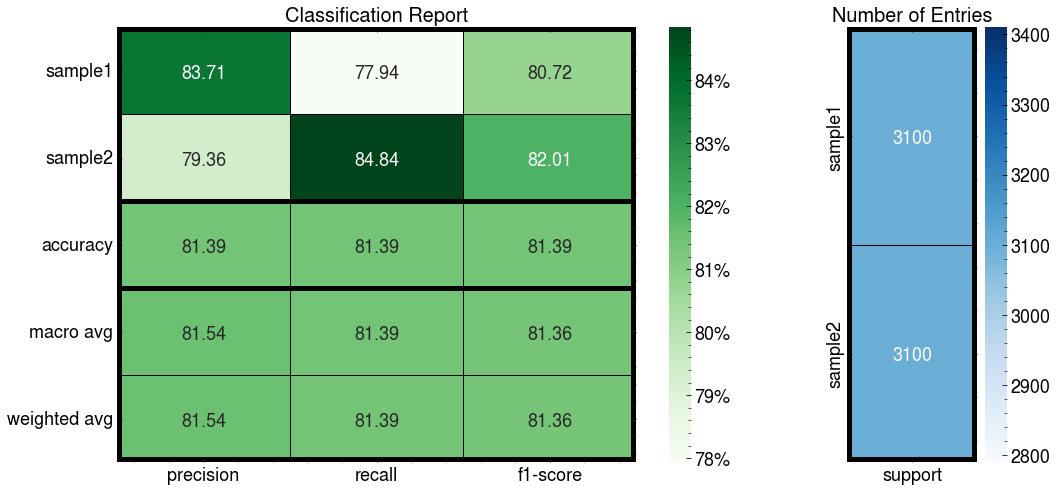

In [ ]:
def classification_report_plotter(algorithm_type):
    """ 
    Classification report plotting function. Parameters: algorithm_type: ('regression', 'binary-classification', 'multiclass-classification').
    """

    if algorithm_type == 'regression':
        print("Not available for regression.")

    elif (algorithm_type == 'binary-classification') or (algorithm_type == 'multiclass-classification'):
        from sklearn.metrics import classification_report

        clf_report = classification_report(
            y_test,
            predictions,
            labels=range(len(np.unique(df['background']))),
            target_names=labels,
            output_dict=True
        )

        fig, ax = plt.subplots(1,2, figsize=(16, 8), gridspec_kw={'width_ratios': [4, 1]})

        sns.heatmap(
            pd.DataFrame(clf_report).iloc[:-1, :].T*100,
            ax=ax[0],
            annot=True, 
            cmap='Greens',
            linewidth=0.5,
            linecolor='black',
            fmt='.2f', 
            annot_kws={"va": 'center_baseline'},
            cbar = True,
            cbar_kws={'format': '%.0f%%'}
        )

        ax[0].hlines(ax[0].get_ylim()[0], ax[0].get_xlim()[0], ax[0].get_xlim()[1], color='black', lw=10)
        ax[0].hlines(ax[0].get_ylim()[1], ax[0].get_xlim()[0], ax[0].get_xlim()[1], color='black', lw=10)
        ax[0].hlines([len(np.unique(df['background']))], ax[0].get_xlim()[0], ax[0].get_xlim()[1], color='black', lw=5)
        ax[0].hlines([len(np.unique(df['background']))+1], ax[0].get_xlim()[0], ax[0].get_xlim()[1], color='black', lw=5)
        ax[0].vlines(ax[0].get_xlim()[0], ax[0].get_ylim()[0], ax[0].get_ylim()[1], color='black', lw=10)
        ax[0].vlines(ax[0].get_xlim()[1], ax[0].get_ylim()[0], ax[0].get_ylim()[1], color='black', lw=10)

        ax[0].set_title('Classification Report')

        sns.heatmap(
            pd.DataFrame(clf_report).iloc[-1::, [x for x in (range(len(np.unique(df['background']))))]].T,
            ax=ax[1],
            annot=True, 
            cmap='Blues',
            linewidth=0.5,
            linecolor='black',
            fmt='.0f', 
            annot_kws={"va": 'center_baseline'},
            cbar = True,
            cbar_kws={'format': '%.0f'}
        )

        ax[1].hlines(ax[1].get_ylim()[0], ax[1].get_xlim()[0], ax[1].get_xlim()[1], color='black', lw=10)
        ax[1].hlines(ax[1].get_ylim()[1], ax[1].get_xlim()[0], ax[1].get_xlim()[1], color='black', lw=10)
        ax[1].vlines(ax[1].get_xlim()[0], ax[1].get_ylim()[0], ax[1].get_ylim()[1], color='black', lw=10)
        ax[1].vlines(ax[1].get_xlim()[1], ax[1].get_ylim()[0], ax[1].get_ylim()[1], color='black', lw=10)

        ax[1].set_title('Number of Entries')

        plt.show()
        
    else:
        raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")

classification_report_plotter(algorithm_type)

#### Confusion Matrix

Displaying a confusion matrix in terms of recall scoring (for binary- and multiclass-classification).

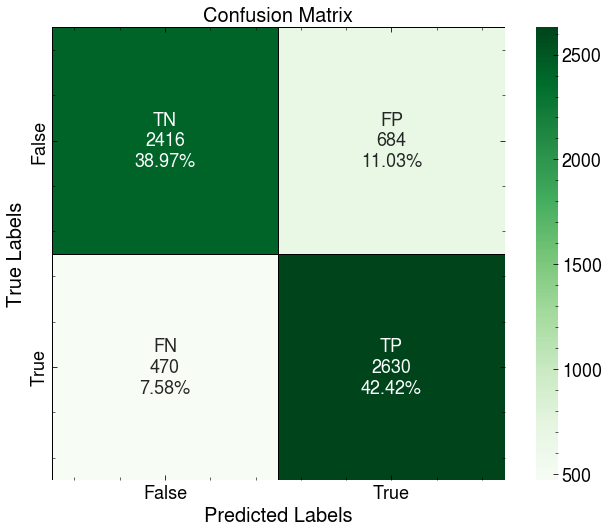

In [ ]:
def confusion_matrix_plotter(algorithm_type):
    """ 
    Confusion matrix plotting function. Parameters: algorithm_type: ('regression', 'binary-classification', 'multiclass-classification').
    """

    if algorithm_type == 'regression':
        print("Not available for regression.")

    elif algorithm_type == 'binary-classification':
        
        from sklearn.metrics import confusion_matrix
        c_matrix = confusion_matrix(y_test, predictions)

        group_names = ['TN','FP','FN','TP']
        group_counts = ["{0:0.0f}".format(value) for value in c_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in c_matrix.flatten()/np.sum(c_matrix)]

        annot = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        annot = np.asarray(annot).reshape(2,2)

        ax= plt.subplot()

        sns.heatmap(
            c_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='Greens', 
            linewidths=1.0, 
            linecolor='black', 
            square=True, 
            fmt='', 
            cbar_kws={'format':'%.0f'}
        )

        ax.set_title('Confusion Matrix')

        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')

        ax.xaxis.set_ticklabels(['False', 'True'])
        ax.yaxis.set_ticklabels(['False', 'True'])

        plt.show()

    elif algorithm_type == 'multiclass-classification':
        from sklearn.metrics import confusion_matrix
        c_matrix = confusion_matrix(y_test, predictions)

        counts = np.array([x for x in c_matrix.flatten()])

        percentages = []
        for x in range(len(np.unique(y))):
            percentages.append(c_matrix[x]/y_test.value_counts()[x]*100)
        percentages = np.round(np.array(percentages).flatten(),2)
        percentages = np.array(list(map("{}%".format, percentages)))

        annot = [f"{v1}\n{v2}" for v1, v2 in zip(counts, percentages)]
        annot = np.asarray(annot).reshape(9,9)

        fig, ax = plt.subplots(1,1, figsize=(12, 12))

        sns.heatmap(
            c_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='Greens', 
            linewidths=1.0, 
            linecolor='black', 
            square=True, fmt='', 
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels
        )

        ax.set_title('Confusion Matrix')

        ax.set_ylabel('True Labels')
        ax.set_xlabel('Predicted Labels')
        
        plt.show()

    else:
        raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")

confusion_matrix_plotter(algorithm_type)

#### ROC & PR Curve

Displaying a Receiver Operating Characteristic and Precision-Recall Curve (for binary- and multiclass-classification).

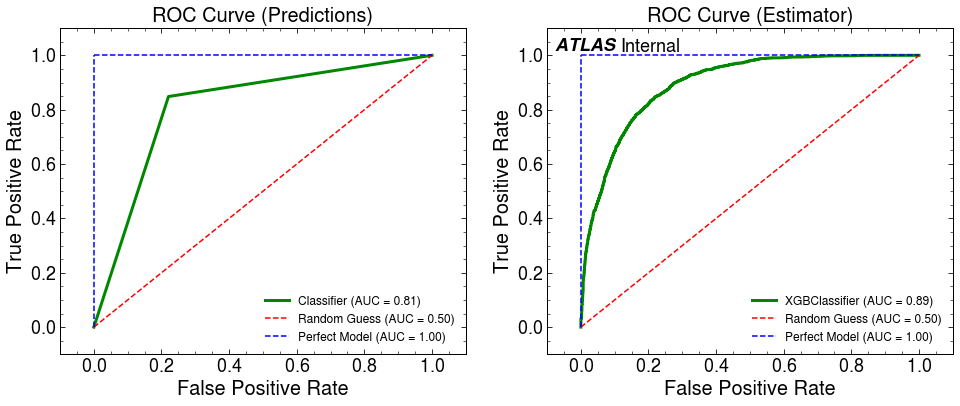

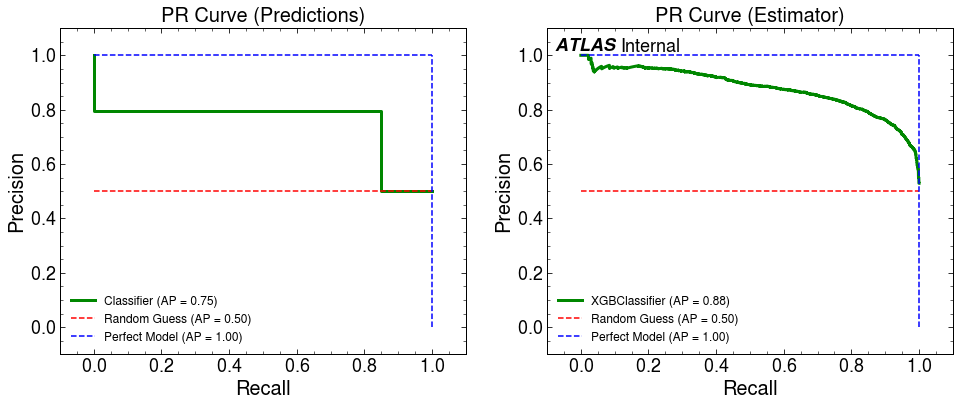

In [ ]:
def curve_plotter(algorithm_type, curve_type):
    """ 
    ROC curve plotting function. Parameters: algorithm_type: ('regression', 'binary-classification', 'multiclass-classification'), curve_type: ('roc' - receiver operating characteristic, 'pr' - precision recall).
    """

    if algorithm_type == 'regression':
        print("Not available for regression.")
        
    elif algorithm_type == 'binary-classification':
        fig, ax = plt.subplots(1,2, figsize=(16, 6))

        if curve_type == 'roc':
            from sklearn.metrics import RocCurveDisplay
            
            RocCurveDisplay.from_predictions(y_test, predictions, ax=ax[0], linewidth=3)
            RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax[1], linewidth=3)

            ax[0].plot([0,1], [0,1], '--', color='red', label='Random Guess (AUC = 0.50)')
            ax[0].plot([0,0], [0,1], '--', color='blue', label='Perfect Model (AUC = 1.00)')
            ax[0].plot([0,1], [1,1], '--', color='blue')

            ax[1].plot([0,1], [0,1], '--', color='red', label='Random Guess (AUC = 0.50)')
            ax[1].plot([0,0], [0,1], '--', color='blue', label='Perfect Model (AUC = 1.00)')
            ax[1].plot([0,1], [1,1], '--', color='blue')

            ax[0].set_title('ROC Curve (Predictions)')
            ax[0].set_xlabel('False Positive Rate')
            ax[0].set_ylabel('True Positive Rate')

            ax[1].set_title('ROC Curve (Estimator)')
            ax[1].set_xlabel('False Positive Rate')
            ax[1].set_ylabel('True Positive Rate')

        elif curve_type == 'pr':
            from sklearn.metrics import PrecisionRecallDisplay

            PrecisionRecallDisplay.from_predictions(y_test, predictions, ax=ax[0], linewidth=3)
            PrecisionRecallDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax[1], linewidth=3)

            ax[0].plot([0,1], [0.5,0.5], '--', color='red', label='Random Guess (AP = 0.50)')
            ax[0].plot([1,1], [0,1], '--', color='blue', label='Perfect Model (AP = 1.00)')
            ax[0].plot([0,1], [1,1], '--', color='blue')

            ax[1].plot([0,1], [0.5,0.5], '--', color='red', label='Random Guess (AP = 0.50)')
            ax[1].plot([1,1], [0,1], '--', color='blue', label='Perfect Model (AP = 1.00)')
            ax[1].plot([0,1], [1,1], '--', color='blue')

            ax[0].set_title('PR Curve (Predictions)')
            ax[0].set_xlabel('Recall')
            ax[0].set_ylabel('Precision')

            ax[1].set_title('PR Curve (Estimator)')
            ax[1].set_xlabel('Recall')
            ax[1].set_ylabel('Precision')

        else:
            raise Exception("Unsupported type of a curve. Only 'roc' or 'pr' allowed.")

        ax[0].set_xlim([-0.1, 1.1])
        ax[0].set_ylim([-0.1, 1.1])
        ax[1].set_xlim([-0.1, 1.1])
        ax[1].set_ylim([-0.1, 1.1])

        ax[0].legend(fontsize=12)
        ax[1].legend(fontsize=12)

    elif algorithm_type == 'multiclass-classification':
        from sklearn.preprocessing import label_binarize
        y_test_binarized = label_binarize(y_test, classes=np.arange(len(np.unique(y))))
        # y_test_binarized = label_binarize(y_test, classes=[*range(len(np.unique(y)))])

        fig, ax = plt.subplots(1,1, figsize=(9, 7))
        colors = sns.color_palette("Paired", n_colors = len(np.unique(y)))

        if curve_type == 'roc':
            from sklearn.metrics import roc_curve, auc

            fpr = dict()
            tpr = dict()

            roc_auc = dict()

            for i in range(len(np.unique(y))):
                fpr[i], tpr[i], _ = roc_curve(
                    y_test_binarized[:, i],
                    predictions_proba[:, i]
                )

                roc_auc = auc(
                    fpr[i], 
                    tpr[i]
                )

                plt.plot(
                    fpr[i], 
                    tpr[i], 
                    color=colors[i], 
                    label=f'{labels[i]} (AUC: {np.round(roc_auc, 2)})'
                )

            ax.plot([0,1], [0,1], '--', color='red', label='Random Guess (AUC = 0.50)')
            ax.plot([0,0], [0,1], '--', color='blue', label='Perfect Model (AUC = 1.00)')
            ax.plot([0,1], [1,1], '--', color='blue')

            ax.set_title('ROC Curve')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')

        elif curve_type == 'pr':
            from sklearn.metrics import precision_recall_curve, average_precision_score

            precision = dict()
            recall = dict()

            for i in range(len(np.unique(y))):
                precision[i], recall[i], _ = precision_recall_curve(
                    y_test_binarized[:, i],
                    predictions_proba[:, i]
                )

                ap = average_precision_score(
                    y_test_binarized[:, i], 
                    predictions_proba[:, i]
                )

                plt.plot(
                    recall[i], 
                    precision[i], 
                    color=colors[i],
                    label=f'{labels[i]} (AP: {np.round(ap, 2)})'
                )

            ax.set_title('PR Curve')
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')

            ax.plot([0,1], [0.5,0.5], '--', color='red', label='Random Guess (AP = 0.50)')
            ax.plot([1,1], [0,1], '--', color='blue', label='Perfect Model (AP = 1.00)')
            ax.plot([0,1], [1,1], '--', color='blue')

        else:
            raise Exception("Unsupported type of a curve. Only 'roc' or 'pr' allowed.")
        
        leg = ax.legend(
            fontsize=12,
            bbox_to_anchor=(1.01, 1.015), 
            # loc='upper left', 
            # borderaxespad=0,
            frameon=True
        )
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_linewidth(1.0)


        ax.set_xlim([-0.1, 1.1])
        ax.set_ylim([-0.1, 1.1])

    else:
        raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")

    # ---ATLAS Label---
    ampl.draw_atlas_label(0.02, 0.97)
    # ---ATLAS Label---

    plt.show()

curve_plotter(algorithm_type, 'roc')
curve_plotter(algorithm_type, 'pr')

ImportError: You must install graphviz to plot tree

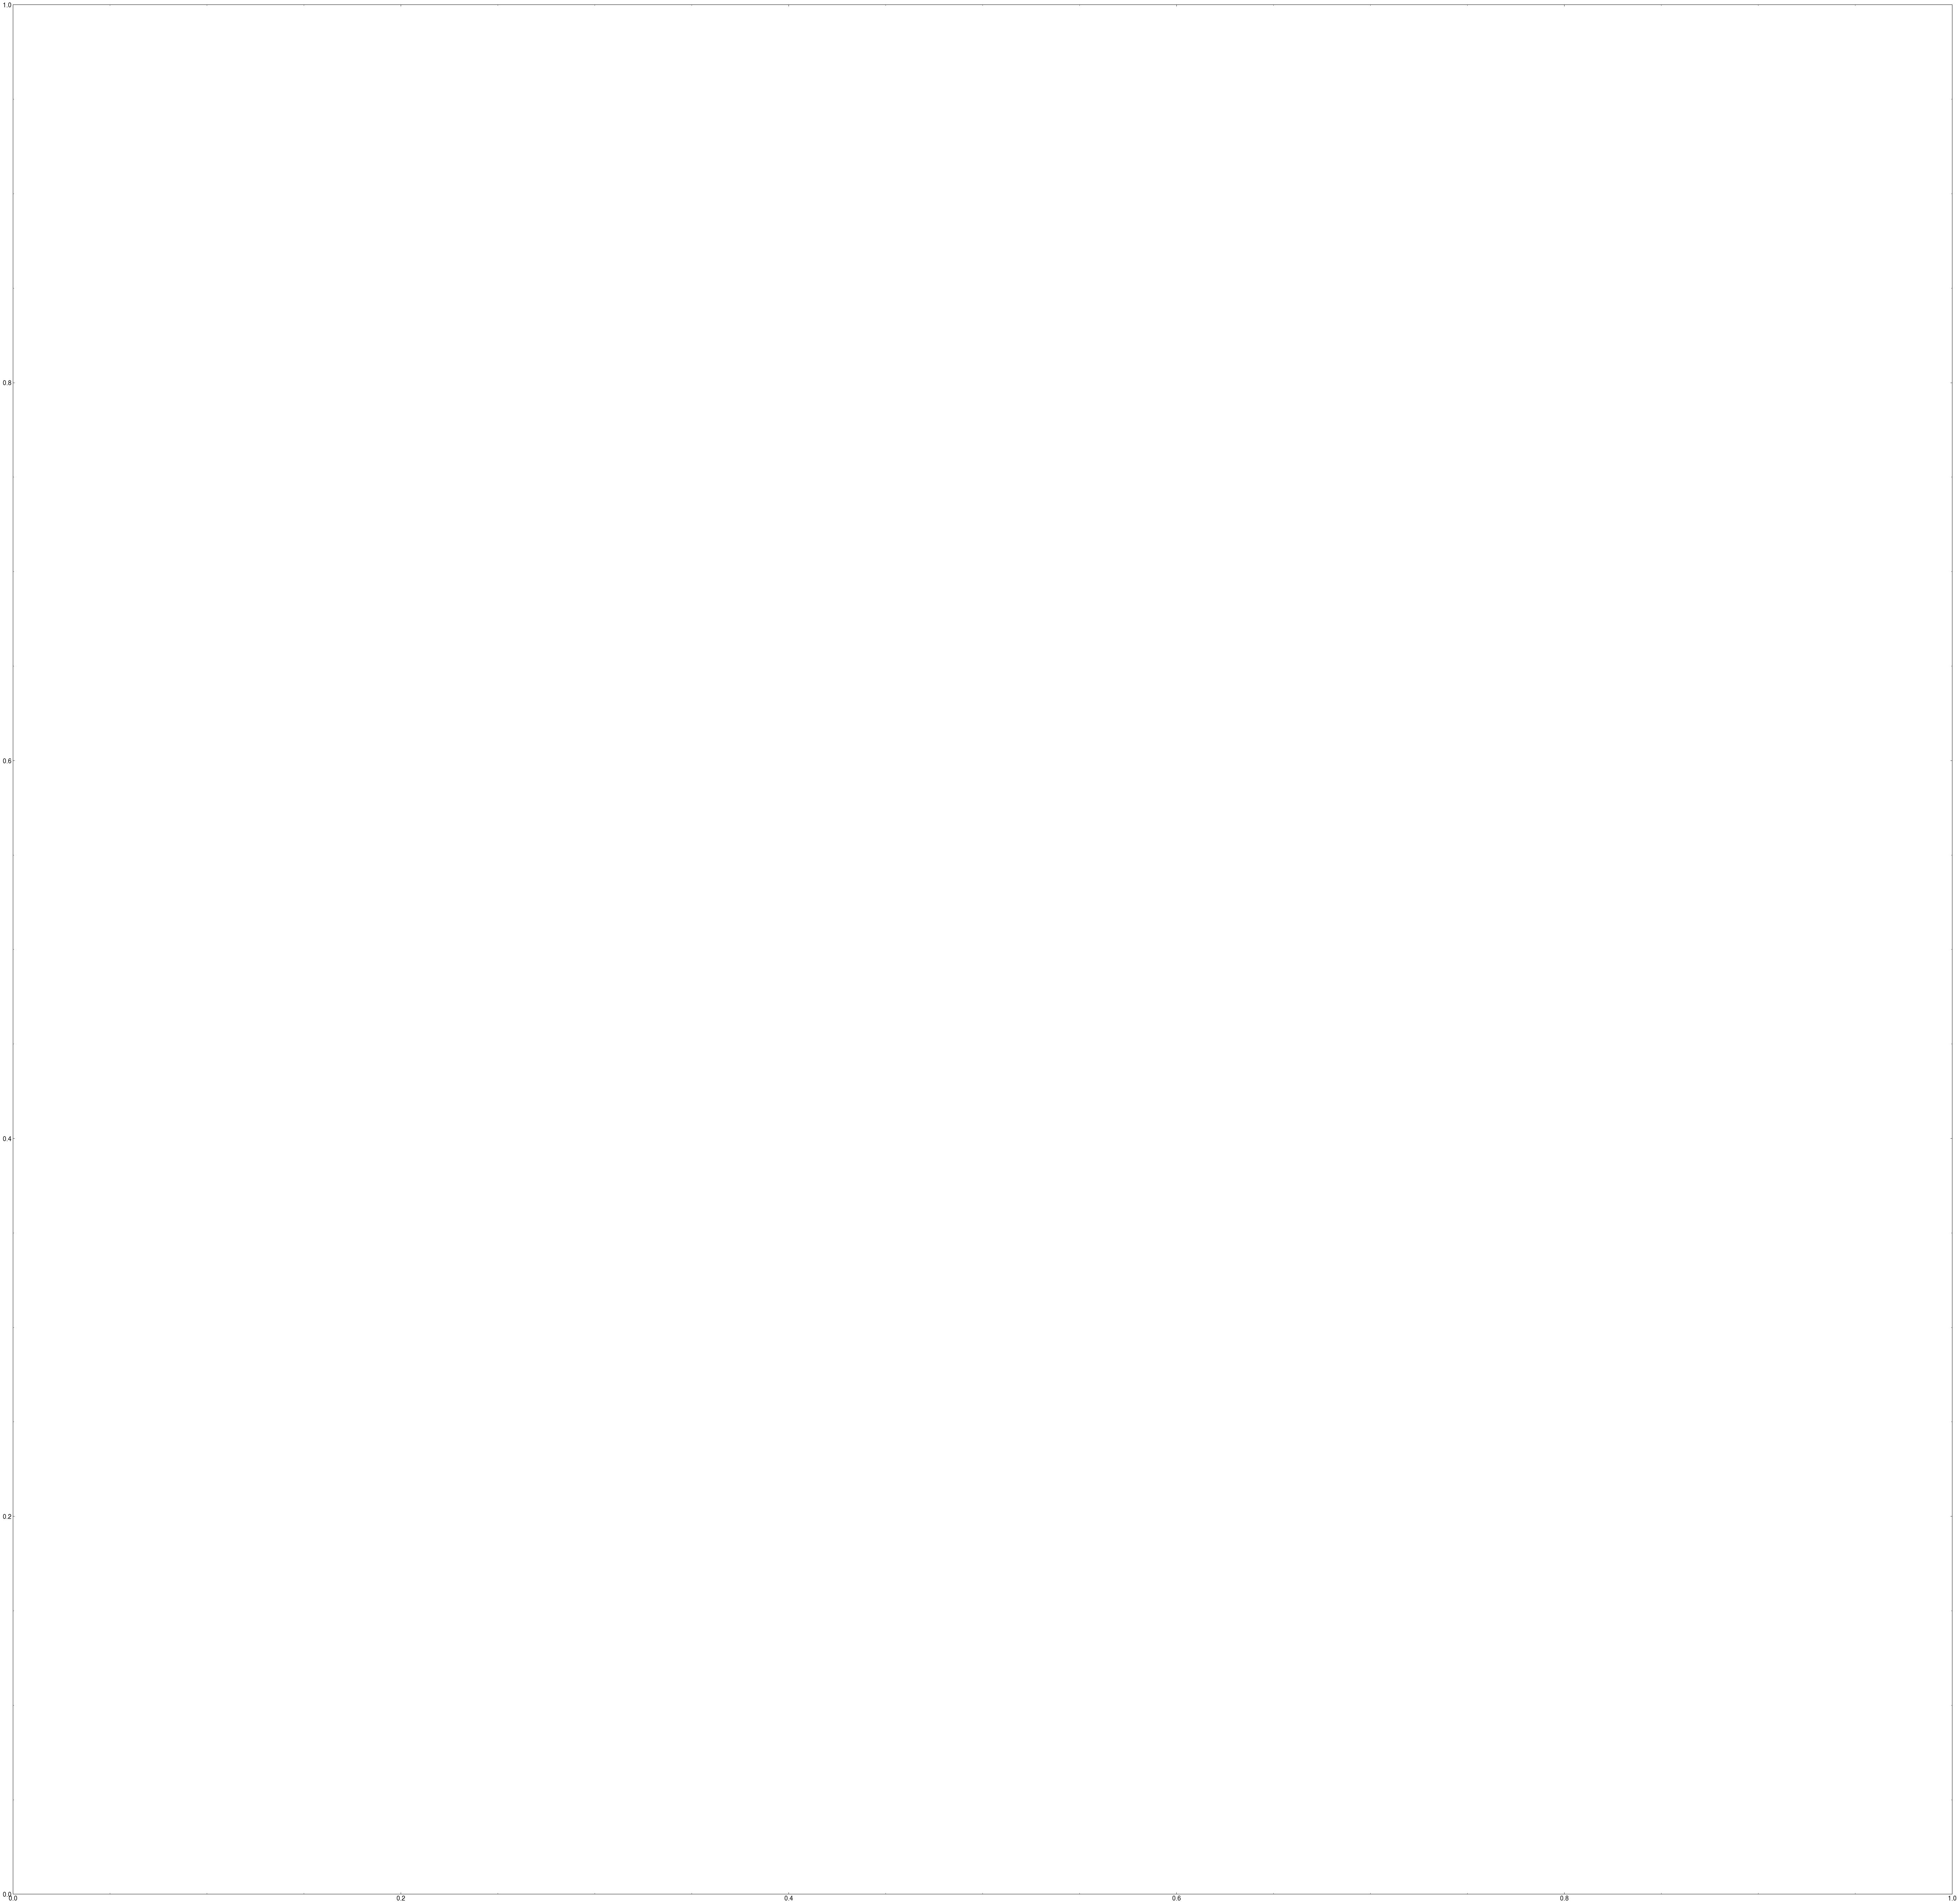

In [ ]:
fig, ax = plt.subplots(figsize=(100, 100))
xgb.plot_tree(xgb_model, ax=ax)
plt.show()

In [ ]:
# xgb_param = xgb_model.get_xgb_params()
# hyperparameters.update({'n_estimators': xgb_model.best_ntree_limit})

#### K-Fold Cross-Validation

Performing a K-Fold Cross-Validation with and without early-stopping-rounds (for binary- and multiclass-classification).

In [ ]:
def k_fold_cross_validator(algorithm_type, k, stopping):
    """ 
    K-fold cross validating function. Parameters: algorithm_type: ('regression', 'binary-classification', 'multiclass-classification'), k: (integer - number of folds), stopping (boolean - enable / disable early stopping round).
    """

    from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

    cv = RepeatedStratifiedKFold(
        n_splits=k,
        n_repeats=1,
        random_state=1
    )

    if algorithm_type == 'regression':
        print('Not available for regression.')

    elif (algorithm_type == 'binary-classification') or (algorithm_type == 'multiclass-classification'):
        scoring = 'accuracy'

        if stopping:
            fit_paramseters_cv = {
                "eval_set":[(X_train, y_train), (X_test, y_test)],
                'eval_metric':metric,
                'early_stopping_rounds':50,
                'verbose':0
            }

            xgb_cv = cross_val_score(
                estimator = xgb_model,
                X = X_train, y = y_train,
                cv = cv, 
                scoring = scoring,
                # n_jobs = -1,
                fit_params = fit_paramseters_cv
            )
            print(f"Mean {scoring} score equals {np.round(np.mean(xgb_cv)*100,2)}% for the {k}-folds with early-stopping-round functionality.")

        else:
            xgb_cv = cross_val_score(
                estimator = xgb_model,
                X = X_train, y = y_train,
                cv = cv, 
                scoring = scoring,
                # n_jobs = -1,
            )
            print(f"Mean {scoring} score equals {np.round(np.mean(xgb_cv)*100,2)}% for the {k}-folds without early-stopping-round functionality.")

    else:
        raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")

k_fold_cross_validator(algorithm_type, 3, True)
k_fold_cross_validator(algorithm_type, 3, False)

Mean accuracy score equals 89.92% for the 3-folds with early-stopping-round functionality.
Mean accuracy score equals 89.92% for the 3-folds without early-stopping-round functionality.


### Grid Search

Performing a grid search to find the best combination of parameter values (for binary- and multiclass-classification).

In [ ]:
parameters_grid_randomized = {
    'n_estimators': [25, 50, 75, 100, 150, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 10, 15],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5, 10, 100],
    'subsample': [0.3, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1, 10, 25, 50, 100],
    'reg_lambda': [0, 0.1, 0.5, 1, 10, 25, 50, 100],
}

parameters_grid_exhaustive = {
    'n_estimators': [100, 250, 500, 750, 1000],
    'learning_rate': [0.05, 0.10],
    'max_depth': [4, 5, 6],
    # 'min_child_weight': [1, 5, 10],
    # 'gamma': [0.5, 1, 1.5, 2, 5, 10, 100],
    # 'subsample': [0.3, 0.6, 0.8, 1.0],
    # 'colsample_bytree': [0.6, 0.8, 1.0],
    # 'reg_alpha': [0, 0.1, 0.5, 1, 10, 25, 50, 100],
    # 'reg_lambda': [0, 0.1, 0.5, 1, 10, 25, 50, 100],
}


In [ ]:
def grid_searcher(algorithm_type, kind, k):
    """ 
    Grid searching function. Parameters: algorithm_type: ('regression', 'binary-classification', 'multiclass-classification'), kind: ('randomized', 'exhaustive'), k: (integer - number of folds).
    """

    model_empty = xgb.XGBClassifier(
        tree_method = 'gpu_hist', 
        gpu_id = 0,
        random_state = 1
    )

    scoring = 'accuracy'

    fit_paramseters_cv = {
        "eval_set":[(X_train, y_train), (X_test, y_test)],
        'eval_metric':metric,
        'early_stopping_rounds':50,
        'verbose':0
    }

    
    if algorithm_type == 'regression':
        print('Not available for regression.')

    elif (algorithm_type == 'binary-classification') or (algorithm_type == 'multiclass-classification'):
        
        if kind == 'randomized':
            from sklearn.model_selection import RandomizedSearchCV
            
            model_grid_randomized = RandomizedSearchCV(
                estimator = model_empty,
                param_distributions = parameters_grid_randomized,
                cv = k,
                scoring = scoring,
                random_state=1
                # n_jobs = -1,
            )

            model_grid_randomized_best = model_grid_randomized.fit(X_train, y_train, **fit_paramseters_cv)

            print(model_grid_randomized_best.best_params_)

        elif kind == 'exhaustive':
            from sklearn.model_selection import GridSearchCV

            model_grid_full = GridSearchCV(
                estimator = model_empty,
                param_grid = parameters_grid_exhaustive,
                cv = k,
                scoring = scoring,
                random_state=1
                # n_jobs = -1,
            )

            model_grid_full_best = model_grid_full.fit(X_train, y_train, **fit_paramseters_cv)

            print(model_grid_full_best.best_params_)

        else:
            raise Exception("Unsupported type of a grid. Only 'randomized' or 'exhaustive' allowed.")

    else:
        raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")

grid_searcher('randomized', 2)
# grid_searcher('exhaustive', 2)          # takes hell of a time...

{'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 10, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 1.5, 'colsample_bytree': 1.0}


## Histograms

### Regression 

Density Comparison - True vs Predicted

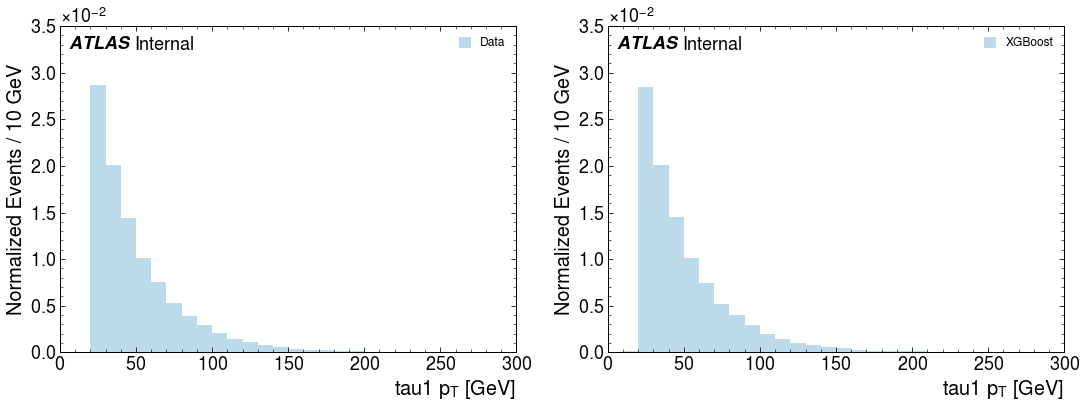

In [ ]:
if algorithm_type == 'regression':
    with PdfPages(f'../Plots/Tau_XGBoost_Density_{flds[0]["name"]}.pdf') as pdf:

        color = sns.color_palette("Paired", n_colors = 1)

        fig, ax = plt.subplots(1,2, figsize=(18,6))
        bins = np.linspace(flds[0]['xaxis_start'], flds[0]['xaxis_end'], flds[0]['bins']+1)

        sns.histplot(
            y, 
            ax=ax[0], 
            bins=bins, 
            stat="density", 
            linewidth=0, 
            color=color,
            label="Data",
        )

        sns.histplot(
            predictions,
            ax=ax[1], 
            bins=bins, 
            stat="density", 
            linewidth=0, 
            color=color,
            label="XGBoost",
        )

        ax[0].set_xlim(flds[0]['xaxis_start'], flds[0]['xaxis_end'])
        ax[1].set_xlim(flds[0]['xaxis_start'], flds[0]['xaxis_end'])

        ymin, ymax = ax[0].get_ylim()
        ax[0].set_ylim([ymin, ymax * 1])
        ax[1].set_ylim([ymin, ymax * 1])

        ax[0].set_ylabel(f"Normalized {flds[0]['yaxis_label']}")
        ax[1].set_ylabel(f"Normalized {flds[0]['yaxis_label']}")
        ax[0].set_xlabel(flds[0]['xaxis_label'], loc="right")
        ax[1].set_xlabel(flds[0]['xaxis_label'], loc="right")

        ax[0].locator_params(nbins=10, axis='y')
        ax[1].locator_params(nbins=10, axis='y')
        ax[0].locator_params(nbins=10, axis='x')
        ax[1].locator_params(nbins=10, axis='x')

        ax[0].ticklabel_format(axis='y', style='sci', scilimits=(-2, 5))
        ax[1].ticklabel_format(axis='y', style='sci', scilimits=(-2, 5))

        # ax[0].yaxis.set_major_formatter(FormatStrFormatter('%0.3f'))
        # ax[1].yaxis.set_major_formatter(FormatStrFormatter('%0.3f'))

        handles, labels = ax[0].get_legend_handles_labels()
        ax[0].legend(handles[::-1], labels[::-1], loc="upper right", prop={'size': 12}, labelspacing = 0.1, handlelength=1, handleheight=1)

        handles, labels = ax[1].get_legend_handles_labels()
        ax[1].legend(handles[::-1], labels[::-1], loc="upper right", prop={'size': 12}, labelspacing = 0.1, handlelength=1, handleheight=1)

        # ---ATLAS Label---
        ampl.draw_atlas_label(-1.18,0.97)
        ampl.draw_atlas_label(0.02,0.97)
        # ---ATLAS Label---

        pdf.savefig(bbox_inches='tight')
        plt.show()

else:
    print("Available only for regression.")

Total Counts Comparison - True vs Predicted

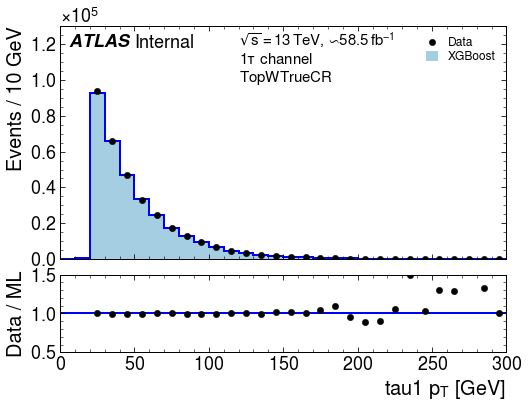

In [ ]:
if algorithm_type == 'regression':
    predictions_full = xgb_model.predict(X)

    with PdfPages(f'../Plots/Tau_XGBoost_Counts_{flds[0]["name"]}.pdf') as pdf:

        color = sns.color_palette("Paired", n_colors = 1)

        fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 6))
        bins = np.linspace(flds[0]['xaxis_start'], flds[0]['xaxis_end'], flds[0]['bins']+1)

        n_ATLAS_Data, bins, patches = ax[0].hist(
            y, 
            bins = bins,
            alpha=0,
        )

        n_ML_Data, bins, patches = ax[0].hist(
            predictions_full,
            bins = bins,
            alpha=0,
        )

        ax[0].hist(
            predictions_full,
            bins = bins,
            histtype = 'bar',
            stacked = True,
            label = "XGBoost",
            color = color
        )

        n_ML_Data, bins, patches = ax[0].hist(
            predictions_full,
            bins = bins,
            histtype = 'step',
            stacked = True,
            color = 'blue',
            linewidth = 2
        )

        n_by_zero = n_ATLAS_Data/n_ATLAS_Data
        n_ATLAS_Data = n_ATLAS_Data*n_by_zero

        bins_center = bins[:-1] + 0.5*(bins[1:] - bins[:-1])

        ax[0].scatter(bins_center, n_ATLAS_Data, marker='o', c='black', s=40, alpha=1, label="Data", zorder=2)

        line = ax[1].axhline(y=1, color='blue', linewidth = 2)
        ax[1].scatter(bins_center, n_ATLAS_Data/n_ML_Data, marker='o', c='black', s=40, alpha=1, zorder=2)


        ax[0].set_xlim(flds[0]['xaxis_start'], flds[0]['xaxis_end'])
        ax[1].set_xlim(flds[0]['xaxis_start'], flds[0]['xaxis_end'])

        ymin, ymax = ax[0].get_ylim()
        ax[0].set_ylim([ymin, ymax * 1.3])
        ax[1].set_ylim([0.5, 1.5])

        ax[0].set_ylabel(flds[0]['yaxis_label'], loc="top")
        ax[1].set_ylabel("Data / ML")
        ax[1].set_xlabel(flds[0]['xaxis_label'], loc="right")

        fig.align_ylabels([ax[0], ax[1]])

        ax[0].locator_params(nbins=10, axis='y')
        ax[1].locator_params(nbins=10, axis='x')

        ax[0].set_xticklabels([])

        ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 5))

        plt.subplots_adjust(hspace = 0.1)


        handles, labels = ax[0].get_legend_handles_labels()
        ax[0].legend(handles[::-1], labels[::-1], loc="upper right", prop={'size': 12}, labelspacing = 0.1, handlelength=1, handleheight=1)

        # ---ATLAS Label---
        ampl.draw_atlas_label(0.02, 4.1)
        # ---ATLAS Label---

        # ---Additional Info Label---
        ax[0].text(
        0.4, 
        0.76, 
        r"$\sqrt{s}=13 \/ TeV, \/ \backsim 58.5 \/ fb^{-1}$" "\n"
        r"$1 \tau \/\/\/ channel$" "\n"
        r"$TopWTrueCR$",
        fontsize=15,
        transform=ax[0].transAxes
        )
        # ---Additional Info Label---

        pdf.savefig(bbox_inches='tight')
        plt.show()

else:
    print("Available only for regression.")